# 第2章 单应变换和估计

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

  单应变换是射影空间下常见的变换，本节主要介绍单应变换及其应用，以及如何求解单应变换。通过本节的提供的例子，能直观感受到多视几何技术在工程领域的作用。
  
  对应参考章节 *计算机视觉多视觉几何 第0篇1.3*

### 单应变换
单应变换也就是射影变换，在生活中非常常见，比如在一张拍摄的照片中，方形地砖不再是方形，汽车的圆形轮胎在画面中是椭圆，无穷远点也不再是无穷远点（回忆第一章的无穷远点章节的例子，地面的平行线在变换到图像中后，在图像中产生了交点）。但是，在经过单应变换后，***直线仍然是直线***。

单应变换是射影空间$IP^2$(齐次三维坐标)的这一种可逆映射$h$，满足三点$x_1,x_2,x_3$共线，变换后的三点$h(x_1),h(x_2),h(x_3)$也共线。是关于齐次三维坐标的一种线性变换，可以用一个$3×3$的矩阵$H$表示为
$$ \left[ \begin{array} {c}
x_1'\\
x_2'\\
x_3'\\
\end{array} \right] = \left[ \begin{array} {ccc}
h_{11}, h_{12}, h_{13}\\
h_{21}, h_{22}, h_{23}\\
h_{31}, h_{32}, h_{33}\\
\end{array} \right]\left[ \begin{array} {c}
x_1\\
x_2\\
x_3\\
\end{array} \right]$$
简洁表示为$x = HX$。矩阵$H$乘以任意一个非零比例因子不会使映射发生改变，通常按照$h_{33}=1$进行归一化，因此一个单应变换有8个自由度。相应的，直线$l$的变换为$$l' = H^{-T}l$$,二次曲线的变换为$$C^{-1}=H^{-T}CH^{-1}$$留意对于同一射影变换$H$，点，线，二次曲线所使用的形式是不同的。

对于单应变换，一种最简单的能够帮助理解的情形如下：对于两个平面，分别建立了自己的$x-y$平面坐标系，那么，每个平面的点分别可以用一个三维齐次坐标来表示，那么从一个平面上的点到另外一个平面上的点的映射，就是一个单应变换。如下图所示，一个平面在image1和image2中分别成像，点集$X,x,x'$互相之间的变换都是一个单应变换。

<img src="./pic/figure/2_1.png", width=320, heigth=240>

<font color=#A9A9A9 size=2><center>Multiple View Geometry in Computer Vision(2nd) P36 </center></font>

**例：由平面诱导的单应变换**

这里用一个"虚拟广告"的例子来说明由平面诱导的单应变换。

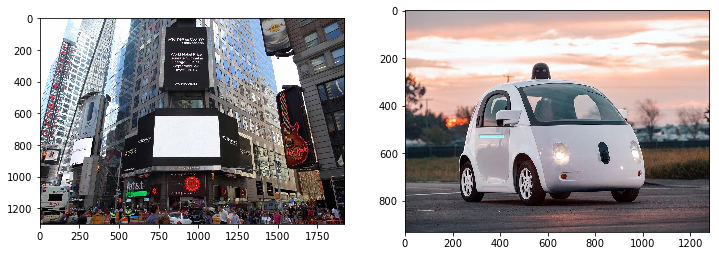

In [5]:
bg_img = cv2.imread("./pic/2_1_1.jpg")
fg_img = cv2.imread("./pic/2_1_2.jpg")

screen_corner = [[725,623], [711, 882], [1138, 880], [1122, 624]]
project_corner = [[0, 0], [0, fg_img.shape[0]], [fg_img.shape[1], fg_img.shape[0]], [fg_img.shape[1],0]]

plt.figure(figsize=(12,12)) 
ax1 = plt.subplot(1,2,1)
plt.imshow(bg_img[:,:,::-1])
ax2 = plt.subplot(1,2,2)
plt.imshow(fg_img[:,:,::-1])

左图中间的白色大屏幕是一个平面，手工标注了白色屏幕四个角点的图像坐标；右图图像也是一个"二维平面"，四个角点分别与屏幕的四个角点相对应。利用单应变换，可以使右边的logo"投射"到左边的大屏幕上。这就是"虚拟广告"的原型，近年来，在诸如NBA的各大球类赛事，都能看到这项技术的应用。通过对场地和相机的事先标定，可以把广告和环境自然地结合。当然，实际情况会比这里的例子复杂得多。

<img src="./pic/figure/2_2.jpg", width=320, heigth=240>

<font color=#A9A9A9 size=2><center>NBA比赛中投影在地面的中文广告 </center></font>
<img src="./pic/figure/2_3.jpg", width=320, heigth=240>

<font color=#A9A9A9 size=2><center>同一个广告牌在各大洲转播时映射不同的广告 </center></font>

这里需要求解单应矩阵，在第一章已经见过它了。为了方便，封装为一个函数接口。这里再一次无需读者了解这里面的数学原理，而是先看看它能够做什么！（具体原理后面会有专门的章节讲解）

In [4]:
#p1s = H * p2s,封装H求解函数
def solveH(p1s, p2s):
    A = []
    for i in range(0, len(p1s)):
        p1 = p1s[i]
        p2 = p2s[i]
        constrain_x = [-p2[0], -p2[1], -1, 0, 0, 0, p2[0]*p1[0], p2[1]*p1[0], p1[0]]
        constrain_y = [0, 0, 0, -p2[0], -p2[1], -1, p2[0]*p1[1], p2[1]*p1[1], p1[1]]
        A.append(constrain_x)
        A.append(constrain_y)
    u, s, vT = np.linalg.svd(A)
    v = vT.T
    H = v[:,-1]
    H = H / H[-1]
    H = H.reshape(3, 3)
    return H

投影残差:
3.1480340112466365e-08
9.223588668786128e-08
1.0226772685360108e-07
4.81981558418148e-09


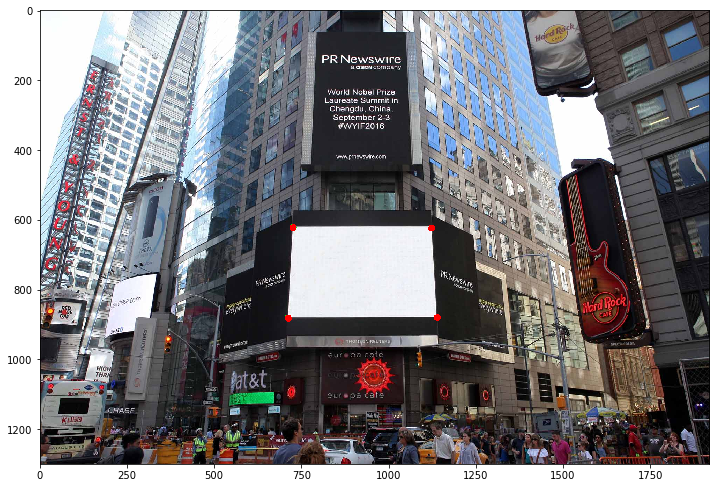

In [7]:
H = solveH(screen_corner, project_corner)

#利用求得的单应变换，投影四个角点并检查投影残差
vis = bg_img.copy()
print("投影残差:")
for i in range(0, len(screen_corner)):
    p1 = np.array(screen_corner[i])
    p2 = np.array([project_corner[i][0], project_corner[i][1], 1])
    p21 = H.dot(p2.T)
    p21 = p21 / p21[-1]
    cv2.circle(vis, (int(p21[0]), int(p21[1])), 10, (0,255,0), -1)
    cv2.circle(vis, (int(p1[0]), int(p1[1])), 10, (0,0,255), -1)
    print(np.linalg.norm(p1 - p21[0:2]))
plt.figure(figsize=(12,12)) 
plt.imshow(vis[:,:,::-1]) 

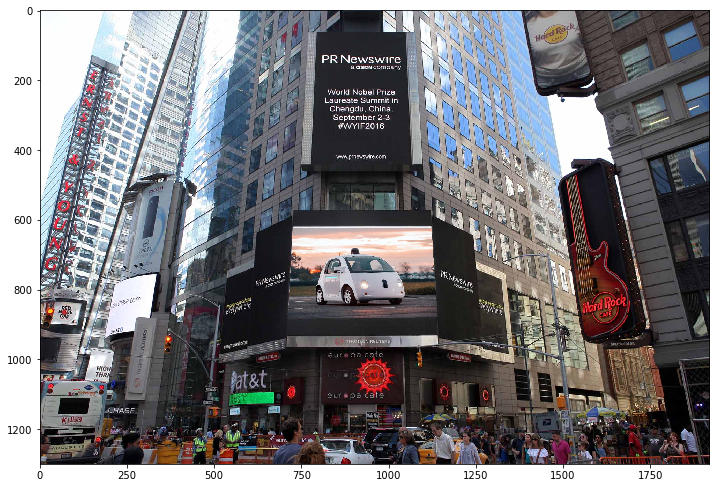

In [8]:
#投影整个logo到广告屏幕上
for i in range(0, fg_img.shape[0], 1):
    for j in range(0, fg_img.shape[1], 1):
        p2 = np.array([j, i, 1])
        p21 = H.dot(p2.T)
        p21 = p21 / p21[-1] 
        bg_img[int(p21[1])][int(p21[0])] = \
            fg_img[i][j]*0.5 + bg_img[int(p21[1])][int(p21[0])] * 0.5
plt.figure(figsize=(12,12)) 
plt.imshow(bg_img[:,:,::-1])

可以看到通过单应变换，虚拟广告完美地投影到了屏幕上。原书还提供了利用单应变换矫正透视失真的例子。方法和投放虚拟广告的例子相似，通过把左图窗户四个角点映射称为标准的长方形来求的单应变换$H$，对整幅图像应用$H$即能实现矫正。
<img src="./pic/figure/2_6.png", width = 500>
<font color=#A9A9A9 size=2><center>消除透视失真 </center></font>

第二种满足单应变换的情况是相机只有纯旋转产生的一组图像。更详细的情况由下面这张图说明。相机成像的过程，可以理解为空间三维点（四维齐次坐标$\mathbb{P}^3$），经过相机中心$\bf{C}$，投影到相机平面（三维齐次坐标$\mathbb{P}^2$）的过程(图a)。图b的情况是前面已经介绍过的第一种常见单应，这是两个平面（图像平面和地平面）之间的变换，是一个单应变换。图c则是只由旋转产生的一组图像，它们之间也是平面之间的变换，是单应变换。比较图b和图c，都是经过同一个相机中心$\bf{C}$的射线，相交在不同平面上形成的交点集合，所以都是单应变换。图d的相机中心发生了变化，所以两幅图像之间不是单应变换；但是如果空间点$X$在同一个平面上，$x$和$x'$由一个单应变换联系。（图e）


总的来说，只要是由同一个相机光心产生的一组图片，那这些图像之间就可以通过单应变换相互投影，而不需要相机内外参和任何的三维结构信息。

<img src="./pic/figure/2_4.png", width = 500>
<font color=#A9A9A9 size=2><center>Multiple View Geometry in Computer Vision(2nd) </center></font>

**例：由纯旋转诱导的单应变换**

这里考察**全景拼接**的例子。

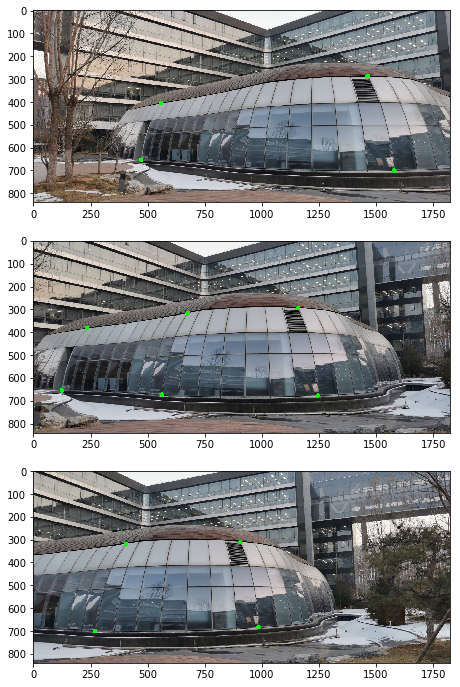

In [9]:
l_img = cv2.imread("./pic/2_2_1.jpg")
m_img = cv2.imread("./pic/2_2_2.jpg")
r_img = cv2.imread("./pic/2_2_3.jpg")
#vis match point
l_m_point = {'p1':[[1463, 288], [1580, 702],[559, 407], [473, 655]],
            'p2':[[1160, 293],[1245, 676], [236, 381], [126, 653]]}
m_r_point = {'p2':[[1160, 293],[1245, 676],[678, 314],[563, 671]],
            'p3':[[906, 311],[986, 682],[406, 318],[272, 700]]}
for p in l_m_point['p1']:
    cv2.circle(l_img, (int(p[0]), int(p[1])), 10, (0,255,0), -1)
for p in l_m_point['p2']:
    cv2.circle(m_img, (int(p[0]), int(p[1])), 10, (0,255,0), -1)
for p in m_r_point['p2']:
    cv2.circle(m_img, (int(p[0]), int(p[1])), 10, (0,255,0), -1)
for p in m_r_point['p3']:
    cv2.circle(r_img, (int(p[0]), int(p[1])), 10, (0,255,0), -1)
plt.figure(figsize=(12,12)) 
ax1 = plt.subplot(3,1,1)
plt.imshow(l_img[:,:,::-1])
ax2 = plt.subplot(3,1,2)
plt.imshow(m_img[:,:,::-1])
ax2 = plt.subplot(3,1,3)
plt.imshow(r_img[:,:,::-1])

这里拍摄了左、中、右三幅图像。对应点分别通过手工标注：左图标注了4个锚点，中图标注了6个锚点，右图标注了4个锚点。分别求解左图到中图、右图到中图的单应（射影）变换，把左图和右图都变换到中间图像上，实现全景拼接。

In [6]:
#求解单应矩阵
Hlm = solveH(l_m_point['p2'], l_m_point['p1'])
Hrm = solveH(m_r_point['p2'], m_r_point['p3'])

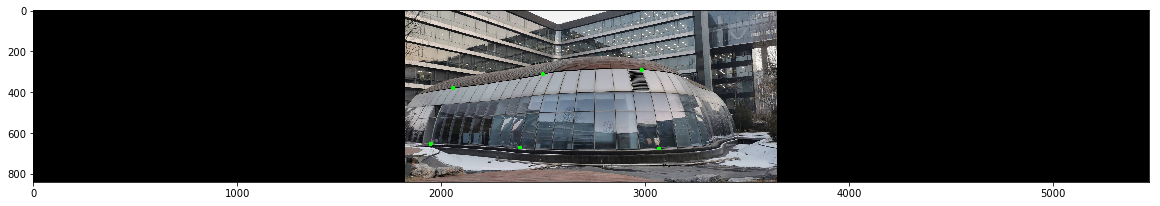

In [7]:
#以中间的图片为基准
fusion_img = np.zeros([l_img.shape[0], l_img.shape[1] *3 ,3],np.uint8)
fusion_img[:, l_img.shape[1]:l_img.shape[1]*2] = m_img
plt.figure(figsize=(20,20)) 
plt.imshow(fusion_img[:,:,::-1])

porcess left image...
porcess right image...


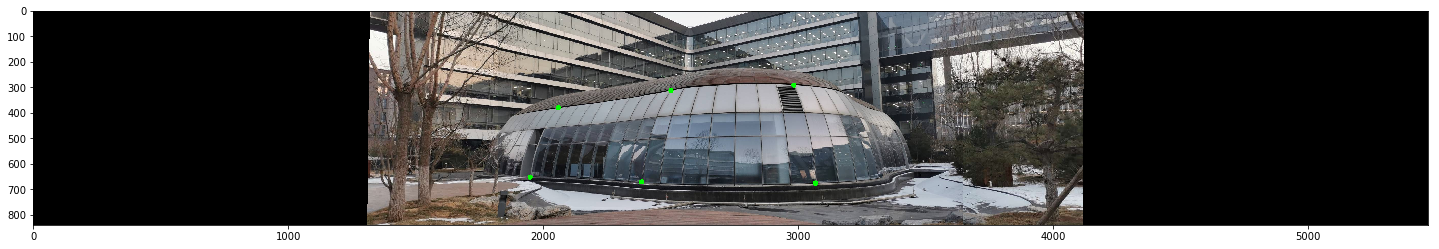

In [21]:
#基于单应变换完成拼接
#源图像投影到目标图像上，会出现『空洞』，需要插值处理（未实现）
def project(source_img, fusion_img, H, offset):  
    W = source_img.shape[1]
    for i in range(0, source_img.shape[0], 1):
        for j in range(0, source_img.shape[1], 1):       
            p2 = np.array([j, i, 1])
            p21 = H.dot(p2.T)
            p21 = p21 / p21[-1]
            if int(p21[1]) > 0 and \
             int(p21[1]) < fusion_img.shape[0] and\
             int(p21[0]) + offset > 0 and\
             (int(p21[0]) + offset < W * 3):
                fusion_img[int(p21[1])][int(p21[0])  + offset] = source_img[i][j]
#目标图像投影到源图像上
def reproject(source_img, fusion_img, H, start, end):  
    w = source_img.shape[1]
    h = source_img.shape[0]
    for i in range(start[0], end[0], 1):
        for j in range(start[1], end[1], 1):       
            p1 = np.array([j - w, i, 1])
            p12 = H.dot(p1.T)
            p12 = p12 / p12[-1]
            if int(p12[1]) > 0 and \
             int(p12[1]) < h and \
             int(p12[0]) > 0 and \
             int(p12[0]) < w:
                fusion_img[i][j] = source_img[int(p12[1])][int(p12[0])]
print("porcess left image...")
reproject(l_img, fusion_img, np.linalg.inv(np.array(Hlm)), [0, 0], [l_img.shape[0],l_img.shape[1]])
print("porcess right image...")
reproject(r_img, fusion_img, np.linalg.inv(np.array(Hrm)), [0, l_img.shape[1]*2], [l_img.shape[0],l_img.shape[1]*3])
plt.figure(figsize=(25,25)) 
plt.imshow(fusion_img[:,:,::-1])

### 估计单应变换

目前为止，已经看到了很多单应变换（即射影变换）的应用，也多次利用两幅图像之间的对应点来估计相应的单应变换，一组对应点的变换方式为
$$ \left[ \begin{array} {c}
x_1'\\
x_2'\\
x_3'\\
\end{array} \right] = \left[ \begin{array} {ccc}
h_{11}, h_{12}, h_{13}\\
h_{21}, h_{22}, h_{23}\\
h_{31}, h_{32}, h_{33}\\
\end{array} \right]\left[ \begin{array} {c}
x_1\\
x_2\\
x_3\\
\end{array} \right]$$
把上式子重写为

$$ \lambda\left[ \begin{array} {c}
x_1'\\x_2'\\1\\
\end{array} \right] = \left[ \begin{array} {ccc}
h_{11}, h_{12}, h_{13}\\h_{21}, h_{22}, h_{23}\\h_{31}, h_{32}, h_{33}\\
\end{array} \right]\left[ \begin{array} {c}
x_1\\x_2\\1\\\end{array} \right]$$

由此可以得到

$$\lambda x_1'=h_{11}x_1+h_{12}x_2+h_{13}$$
$$\lambda x_2'=h_{21}x_1+h_{22}x_2+h_{23}$$
$$\lambda =h_{31}x_1+h_{32}x_2+h_{33}$$

替换$\lambda$有

$$x_1'=\frac{h_{11}x_1+h_{12}x_2+h_{13}}{h_{31}x_1+h_{32}x_2+h_{33}}$$
$$x_2'=\frac{h_{21}x_1+h_{22}x_2+h_{23}}{h_{31}x_1+h_{32}x_2+h_{33}}$$

重新整理得

$$-h_{11}x_1-h_{12}x_2-h_{13}+h_{31}x_1x_1'+h_{32}x_2x_1'+h_{33}x_1'=0$$
$$-h_{21}x_1-h_{22}x_2-h_{23}+h_{31}x_1x_2'+h_{32}x_2x_2'+h_{33}x_2'=0$$

写成矩阵相乘的形式

$$ \left[ \begin{array} {ccccccccc}
-x_1&-x_2&-1&0&0&0&x_1x_1'&x_2x_1'&x_1'\\
0&0&0&-x_1&-x_2&-1&x_1x_2'&x_2x_2'&x_2'\\
\end{array} \right] \left[ \begin{array} {c}
h_{11}\\h_{12}\\h_{13}\\
h_{21}\\h_{22}\\h_{23}\\
h_{31}\\h_{32}\\h_{33}\\
\end{array} \right]=\bf{0}$$

得到了形如$AX=0$的方程，每组点给出了两个约束，单应矩阵一共有8个自由度，所以至少需要4组点对来求解单应矩阵。如果有$n$组对应点，构建的A矩阵的维度为$2n×9$。对于形如$AX=0$问题的解法，再次请读者参考**附录多视几何中常用的数学方法**，并结合前面多次出现的求解单应变换的代码进行理解，在这里不在赘述。
上述求解过程叫做**直接线性变换（DLT）算法**。

本节的最后，对单应变换的求解进行一些简单的讨论。

1 已经知道由点对求解单应变换时，至少需要4组这样的点。而且不能存在3个点共线的情况。

2 **归一化DLT算法**
在前面的例子中，点的坐标都是在图像坐标系下得到的，图像坐标系的原点位于图片的左上角。归一化变换将消除由任意选取图像坐标系的原点和尺度所产生的影响，包括图像坐标的平移和尺度缩放。归一化必须在实施DLT之前进行，然后再对结果进行适当的校正就能得到关于原坐标系的单应矩阵H。原书中指出

>• Data normalization is an essential step in the DLT algorithm. It must not be consid- ered optional.

归一化是一定要做的步骤。

3 使用RANSAC算法，可以实现单应矩阵的自动鲁棒估计。RANSAC算法是一种常用的基本算法，在多视几何算法中经常使用，不在本教程的介绍范围之内，读者可以自己查找相关资料。

**例：归一化的必要性**
<img src="./pic/figure/2_5.png", width = 500>
用原书的例子考察DLT算法中单应变换的必要性。选择平面的五点，并将其投影到本身，此时的单应矩阵是一个单位阵。进行100实验迭代，每次添加0.1高斯误差，并分别求未进行归一化和进行归一化后的单应矩阵。用作测试的点是较远的一个点（5000，5000），比较二者的投影误差均值和方差。

图a是未进行归一化的测试点的投影误差，图b是进行归一化后的测试点的投影误差。从代码仿真结果可以看到，归一化的效果是显著的。

归一化方法是多样的。原书提供的方法是将原点平移到点的均值出，并且使它们到原点的平均距离是$\sqrt2$. 在ORBSLAM中，使它们到原点的平均距离是1.

In [23]:
import copy
# data prepare
match_point = {'p1':[[500, 500], [1000, 750],[1500, 1000], [2000, 750],[2500,500]],
            'p2':[[500, 500], [1000, 750],[1500, 1000], [2000, 750],[2500,500]],}
test_point = np.array([300, 1500])     

In [24]:
def Normalization(p):
    # 使用原书提到的归一化方法：把点集变化到原点位于中心点处，并且使它们到原点的平均距离是sqrt(2)
    mean = p.mean(axis=0)
    dist = p - mean
    dist = np.mean(np.linalg.norm(dist,axis=1))
    scale = np.sqrt(2) / dist
    similarity_transformation = \
        np.array([[scale, 0, -mean[0]* scale],
                 [0, scale, -mean[1] * scale],
                 [0, 0, 1],])
    return similarity_transformation

ite = 100
error = []
error_m = []
for iteration in range(ite):
    m_p = copy.deepcopy(match_point)
    for k, v in m_p.items():
        #add 0.1 guassion noise per iteration
        for p in v:
            p[0] += np.random.normal(0, 0.1 * iteration)
            p[1] += np.random.normal(0, 0.1 * iteration)
    #得到归一化变换矩阵
    T1 = Normalization(np.array(m_p['p1']))
    T2 = Normalization(np.array(m_p['p2']))
    T_dict = {'p1':T1, 'p2':T2}
    
    #求归一化后的点
    m_p_norm = copy.deepcopy(m_p)
    for k, v in m_p_norm.items():
        for p in v:
            p_h = np.array([p[0],p[1],1])
            p_norm = T_dict[k].dot(np.array(p_h))
            p[0] = p_norm[0] / p_norm[2]
            p[1] = p_norm[1] / p_norm[2]
            
    #未进行归一化求单应矩阵
    H= solveH(m_p['p2'], m_p['p1'])
    #进行归一化求单应矩阵
    H_norm = solveH(m_p_norm['p2'], m_p_norm['p1'])
    H_norm = np.dot(np.linalg.inv(T2), np.dot(H_norm , T1))
    
    p_test = np.array([test_point[0],test_point[1], 1])
    p21 = H.dot(p_test.T)
    p21 = p21 / p21[-1]
    error.append(np.linalg.norm(test_point - p21[0:2]))
    p21 = H_norm.dot(p_test.T)
    p21 = p21 / p21[-1]
    error_m.append(np.linalg.norm(test_point - p21[0:2]))
    
error = np.array(error)
error_m = np.array(error_m)
print("未进行归一化，投影的误差均值: ", np.mean(error), " 误差方差: ", np.var(error) )
print("进行归一化，投影的误差均值: ", np.mean(error_m), " 误差方差: ", np.var(error_m) )

未进行归一化，投影的误差均值:  219.9661116896528  误差方差:  301315.62007732556
进行归一化，投影的误差均值:  75.55710880392415  误差方差:  6302.509953515611
